# QLoRA Fine-Tuning for CLIP

This notebook fine-tunes CLIP using **QLoRA** (Quantized LoRA) on the food recipe dataset.

**Hypothesis H1:** The fine-tuned model improves text↔image alignment compared to the CLIP baseline, measured with retrieval metrics (R@K, MRR).

**This notebook (M1 QLoRA):**
- Loads pre-trained CLIP model with 4-bit quantization
- Applies LoRA adapters to trainable modules
- Fine-tunes on training set using CLIP contrastive loss
- Evaluates on test set with same metrics as baseline
- Saves adapters, logs, and results for comparison

**Inputs:**
- `fine-tuning-zone/datasets/train_manifest.csv` (for training)
- `fine-tuning-zone/datasets/test_manifest.csv` (for evaluation)
- `fine-tuning-zone/images/` and `fine-tuning-zone/augmented_images/` (images)

**Outputs:**
- `fine-tuning-zone/experiments/qlora/run_{run_id}/` — Complete run directory with:
  - `config.yaml` — Training configuration
  - `adapters/` — LoRA adapter weights
  - `training_logs.json` — Loss and timing logs
  - `results_qlora.json` — Evaluation metrics
  - `examples_top5.json` — Qualitative examples


## 1. Setup and Configuration


In [16]:
import os
import io
import json
import hashlib
import time
import sys
import psutil
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Check Python environment
print("=" * 60)
print("Python Environment Check")
print("=" * 60)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Check if we're in a virtual environment
venv_path = Path(sys.executable).parent.parent
if (venv_path / "pyvenv.cfg").exists() or "venv" in str(sys.executable).lower():
    print(f"✓ Running in virtual environment: {venv_path}")
else:
    print(f"⚠ Not in a virtual environment")
    print(f"  Current Python: {sys.executable}")
    print(f"  If you have a venv, make sure Jupyter is using it!")

import numpy as np
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from tqdm import tqdm
import yaml

# CLIP and QLoRA imports
TRANSFORMERS_AVAILABLE = False
PEFT_AVAILABLE = False
BITSANDBYTES_AVAILABLE = False

try:
    from transformers import CLIPModel, CLIPProcessor
    TRANSFORMERS_AVAILABLE = True
    print("✓ transformers imported successfully")
except ImportError as e:
    print(f"✗ Failed to import transformers: {e}")

try:
    from transformers import BitsAndBytesConfig
    BITSANDBYTES_AVAILABLE = True
    print("✓ BitsAndBytesConfig imported successfully")
except ImportError as e:
    print(f"⚠ BitsAndBytesConfig not available: {e}")
    print("  Note: bitsandbytes may not be available on Windows or CPU-only systems")

try:
    from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
    PEFT_AVAILABLE = True
    print("✓ peft imported successfully")
except ImportError as e:
    print(f"✗ Failed to import peft: {e}")

print("\n" + "=" * 60)
print("Library Status")
print("=" * 60)
if not TRANSFORMERS_AVAILABLE:
    print("  ✗ transformers: NOT AVAILABLE")
    print("    Install with: pip install transformers")
else:
    print("  ✓ transformers: AVAILABLE")
    
if not PEFT_AVAILABLE:
    print("  ✗ peft: NOT AVAILABLE")
    print("    Install with: pip install peft")
else:
    print("  ✓ peft: AVAILABLE")
    
if not BITSANDBYTES_AVAILABLE:
    print("  ⚠ bitsandbytes: NOT AVAILABLE (optional)")
    print("    Note: bitsandbytes may not work on Windows/CPU.")
    print("    You can still use LoRA without quantization.")
else:
    print("  ✓ bitsandbytes: AVAILABLE")

if TRANSFORMERS_AVAILABLE and PEFT_AVAILABLE:
    print("\n✓ All required libraries are available!")
    print("  You can proceed with training.")
elif not TRANSFORMERS_AVAILABLE or not PEFT_AVAILABLE:
    print("\n✗ Some required libraries are missing!")
    print("  Please install missing libraries before continuing.")

# Load environment variables
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

ENV_PATHS = [
    PROJECT_ROOT / "notebooks" / ".env",
    PROJECT_ROOT / "app" / ".env",
    PROJECT_ROOT / ".env",
]

env_loaded = False
for env_path in ENV_PATHS:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    print("⚠ No .env file found, trying default load_dotenv()...")
    load_dotenv()

# MinIO Configuration
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")

# Bucket configuration
FINE_TUNING_BUCKET = "fine-tuning-zone"
DATASETS_PREFIX = "datasets"
IMAGES_PREFIX = "images"
AUGMENTED_IMAGES_PREFIX = "augmented_images"
EXPERIMENTS_PREFIX = "experiments"

# Input/Output paths
TRAIN_AUGMENTED_KEY = f"{DATASETS_PREFIX}/train_pairs_augmented_with_negatives.csv"
TEST_MANIFEST_KEY = f"{DATASETS_PREFIX}/train_pairs_positive.csv"  # Test set from baseline split
DATASET_REPORT_KEY = f"{DATASETS_PREFIX}/dataset_report.json"

# Model configuration
MODEL_NAME = "openai/clip-vit-base-patch32"  # Same as baseline
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# QLoRA configuration
QLORA_CONFIG = {
    "load_in_4bit": True,
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": True,
    "bnb_4bit_compute_dtype": torch.float16 if torch.cuda.is_available() else torch.float32,
}

# LoRA configuration
LORA_CONFIG = {
    "r": 8,
    "lora_alpha": 16,
    "lora_dropout": 0.05,
    "bias": "none",
    "task_type": "FEATURE_EXTRACTION",
    "target_modules": ["q_proj", "k_proj", "v_proj", "out_proj", "text_projection", "visual_projection"],
}

# Training configuration
TRAINING_CONFIG = {
    "learning_rate": 1e-4,
    "num_epochs": 3,
    "batch_size": 8,  # Smaller batch for QLoRA
    "gradient_accumulation_steps": 4,  # Effective batch size = 8 * 4 = 32
    "warmup_steps": 100,
    "save_steps": 500,
    "logging_steps": 50,
    "random_seed": 42,
}

# Evaluation configuration (same as baseline)
K_VALUES = [1, 5, 10]
COMPUTE_MRR = True

# Generate run ID
RUN_ID = f"qlora_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"
RUN_DIR = f"{EXPERIMENTS_PREFIX}/qlora/run_{RUN_ID}"

# Output paths
CONFIG_KEY = f"{RUN_DIR}/config.yaml"
ADAPTERS_DIR = f"{RUN_DIR}/adapters"
LOGS_KEY = f"{RUN_DIR}/training_logs.json"
RESULTS_KEY = f"{RUN_DIR}/results_qlora.json"
EXAMPLES_KEY = f"{RUN_DIR}/examples_top5.json"

# Update config to include dataset info
TRAINING_CONFIG["train_dataset"] = TRAIN_AUGMENTED_KEY
TRAINING_CONFIG["test_dataset"] = TEST_MANIFEST_KEY
TRAINING_CONFIG["filter_applied"] = "label == 1 (positive pairs only)"

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {DEVICE}")
print(f"  QLoRA: 4-bit quantization enabled")
print(f"  LoRA r: {LORA_CONFIG['r']}, alpha: {LORA_CONFIG['lora_alpha']}")
print(f"  Training: {TRAINING_CONFIG['num_epochs']} epochs, LR={TRAINING_CONFIG['learning_rate']}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']} (effective: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']})")
print(f"  Run ID: {RUN_ID}")


Python Environment Check
Python executable: c:\Users\DOCT\Documents\UNI\ADSDB\adsdb-multimodal-food-data-management\venv\Scripts\python.exe
Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
✓ Running in virtual environment: c:\Users\DOCT\Documents\UNI\ADSDB\adsdb-multimodal-food-data-management\venv
✓ transformers imported successfully
✓ BitsAndBytesConfig imported successfully
✓ peft imported successfully

Library Status
  ✓ transformers: AVAILABLE
  ✓ peft: AVAILABLE
  ✓ bitsandbytes: AVAILABLE

✓ All required libraries are available!
  You can proceed with training.
✓ Loaded .env from: c:\Users\DOCT\Documents\UNI\ADSDB\adsdb-multimodal-food-data-management\app\.env
Configuration:
  Model: openai/clip-vit-base-patch32
  Device: cpu
  QLoRA: 4-bit quantization enabled
  LoRA r: 8, alpha: 16
  Training: 3 epochs, LR=0.0001
  Batch size: 8 (effective: 32)
  Run ID: qlora_20260103_093822


C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\371299066.py:174: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_ID = f"qlora_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"


## 2. Initialize MinIO Client


In [17]:
# Initialize S3/MinIO client
session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

def ensure_bucket_exists(bucket: str) -> bool:
    """Create bucket if it doesn't exist."""
    try:
        s3.head_bucket(Bucket=bucket)
        return True
    except ClientError as e:
        error_code = e.response.get("Error", {}).get("Code", "")
        if error_code in ("404", "NoSuchBucket"):
            try:
                s3.create_bucket(Bucket=bucket)
                print(f"✓ Created bucket '{bucket}'")
                return True
            except ClientError as create_error:
                print(f"✗ Failed to create bucket '{bucket}': {create_error}")
                return False
        return False

# Verify buckets
print("Checking buckets...")
ensure_bucket_exists(FINE_TUNING_BUCKET)
print("✓ Buckets ready")


Checking buckets...
✓ Buckets ready


## 3. Load Training and Test Datasets


In [18]:
def load_csv_from_minio(bucket: str, key: str) -> pd.DataFrame:
    """Load CSV file from MinIO into a DataFrame."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        print(f"✓ Loaded {len(df)} rows from s3://{bucket}/{key}")
        return df
    except ClientError as e:
        print(f"✗ Failed to load s3://{bucket}/{key}: {e}")
        return pd.DataFrame()

# Load training dataset (augmented, with negatives)
print("Loading augmented training dataset...")
train_full_df = load_csv_from_minio(FINE_TUNING_BUCKET, TRAIN_AUGMENTED_KEY)

if train_full_df.empty:
    raise RuntimeError(f"Could not load training data from s3://{FINE_TUNING_BUCKET}/{TRAIN_AUGMENTED_KEY}")

print(f"\nFull training dataset shape: {train_full_df.shape}")
print(f"Columns: {list(train_full_df.columns)}")
if "label" in train_full_df.columns:
    print(f"\nLabel distribution:")
    print(train_full_df["label"].value_counts())
    
    # Filter only positive pairs (label=1)
    train_df = train_full_df[train_full_df["label"] == 1].copy()
    print(f"\n✓ Filtered to {len(train_df)} positive pairs (label=1)")
    print(f"  Removed {len(train_full_df) - len(train_df)} negative pairs")
else:
    # If no label column, assume all are positive
    train_df = train_full_df.copy()
    print(f"\n✓ No label column found, using all {len(train_df)} pairs as positive")

# Load test dataset (from baseline split, already filtered)
print("\nLoading test dataset...")
test_df = load_csv_from_minio(FINE_TUNING_BUCKET, TEST_MANIFEST_KEY)

if test_df.empty:
    raise RuntimeError(f"Could not load test data from s3://{FINE_TUNING_BUCKET}/{TEST_MANIFEST_KEY}")

print(f"\nTraining dataset:")
print(f"  Pairs: {len(train_df)}")
print(f"  Recipes: {train_df['recipe_id'].nunique()}")
print(f"  Images: {train_df['image_key'].nunique()}")
print(f"  Captions: {train_df['caption'].nunique()}")

print(f"\nTest dataset:")
print(f"  Pairs: {len(test_df)}")
print(f"  Recipes: {test_df['recipe_id'].nunique()}")
print(f"  Images: {test_df['image_key'].nunique()}")
print(f"  Captions: {test_df['caption'].nunique()}")


Loading augmented training dataset...
✓ Loaded 1790 rows from s3://fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv

Full training dataset shape: (1790, 4)
Columns: ['recipe_id', 'image_key', 'caption', 'label']

Label distribution:
label
1    1432
0     358
Name: count, dtype: int64

✓ Filtered to 1432 positive pairs (label=1)
  Removed 358 negative pairs

Loading test dataset...
✓ Loaded 358 rows from s3://fine-tuning-zone/datasets/train_pairs_positive.csv

Training dataset:
  Pairs: 1432
  Recipes: 216
  Images: 1074
  Captions: 430

Test dataset:
  Pairs: 358
  Recipes: 216
  Images: 358
  Captions: 215


## 4. Helper Functions for Image Loading


In [19]:
def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    """Load an image from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except Exception as e:
        return None

def get_image_path_in_minio(image_key: str) -> Tuple[str, str]:
    """
    Determine bucket and full key for an image.
    
    Images can be in:
    - fine-tuning-zone/images/...
    - fine-tuning-zone/augmented_images/...
    """
    bucket = FINE_TUNING_BUCKET
    
    # Check if it's already a full path or just a key
    if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
        key = image_key
    else:
        # Try images first, then augmented_images
        key = f"{IMAGES_PREFIX}/{image_key}"
    
    return bucket, key


## 5. Load CLIP Model with QLoRA


In [20]:
if not TRANSFORMERS_AVAILABLE or not PEFT_AVAILABLE:
    raise ImportError("Required libraries not available. Install: pip install transformers peft")

print(f"Loading CLIP model with QLoRA: {MODEL_NAME}")
print(f"Device: {DEVICE}")

# Configure 4-bit quantization (only if bitsandbytes is available)
if BITSANDBYTES_AVAILABLE and torch.cuda.is_available():
    print("Using 4-bit quantization with BitsAndBytes...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=QLORA_CONFIG["load_in_4bit"],
        bnb_4bit_quant_type=QLORA_CONFIG["bnb_4bit_quant_type"],
        bnb_4bit_use_double_quant=QLORA_CONFIG["bnb_4bit_use_double_quant"],
        bnb_4bit_compute_dtype=QLORA_CONFIG["bnb_4bit_compute_dtype"],
    )
    quantization_config = bnb_config
    use_quantization = True
else:
    print("⚠ BitsAndBytes not available or no CUDA. Using LoRA without quantization (regular LoRA, not QLoRA)")
    quantization_config = None
    use_quantization = False
    # Update config to reflect this
    QLORA_CONFIG["load_in_4bit"] = False

# Load model
print("Loading model...")
if use_quantization:
    model = CLIPModel.from_pretrained(
        MODEL_NAME,
        quantization_config=quantization_config,
        device_map="auto" if torch.cuda.is_available() else None,
    )
else:
    model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)

# Load processor
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

# Prepare model for k-bit training (only if using quantization)
if use_quantization:
    print("Preparing model for k-bit training...")
    model = prepare_model_for_kbit_training(model)
else:
    print("Model ready for training (no quantization)")

# Configure LoRA
lora_config = LoraConfig(
    r=LORA_CONFIG["r"],
    lora_alpha=LORA_CONFIG["lora_alpha"],
    lora_dropout=LORA_CONFIG["lora_dropout"],
    bias=LORA_CONFIG["bias"],
    task_type=LORA_CONFIG["task_type"],
    target_modules=LORA_CONFIG["target_modules"],
)

# Apply LoRA adapters
print("Applying LoRA adapters...")
model = get_peft_model(model, lora_config)

# Print trainable parameters
print("\n" + "=" * 60)
print("Model Information")
print("=" * 60)
model.print_trainable_parameters()

# Get model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Trainable ratio: {trainable_params/total_params*100:.2f}%")


Loading CLIP model with QLoRA: openai/clip-vit-base-patch32
Device: cpu
⚠ BitsAndBytes not available or no CUDA. Using LoRA without quantization (regular LoRA, not QLoRA)
Loading model...
Model ready for training (no quantization)
Applying LoRA adapters...

Model Information
trainable params: 1,001,472 || all params: 152,278,785 || trainable%: 0.6577

✓ Model loaded successfully
  Total parameters: 152,278,785
  Trainable parameters: 1,001,472
  Trainable ratio: 0.66%


## 6. Create DataLoader for Training


In [21]:
from torch.utils.data import Dataset, DataLoader
import random

class CLIPDataset(Dataset):
    """Dataset for CLIP training with image-text pairs."""
    
    def __init__(self, df: pd.DataFrame, processor, s3_client, bucket: str):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.s3 = s3_client
        self.bucket = bucket
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        bucket, key = get_image_path_in_minio(row["image_key"])
        img = load_image_from_minio(bucket, key)
        
        if img is None:
            # Return a placeholder if image fails to load
            img = Image.new("RGB", (224, 224), color="black")
        
        # Get caption
        caption = row["caption"]
        
        return {
            "image": img,
            "text": caption,
        }

def collate_fn(batch):
    """Collate function for DataLoader."""
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    
    # Process with CLIP processor
    # Process text and images together (CLIPProcessor handles this correctly)
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    
    # Filter to only include what CLIPModel.forward() accepts
    # CLIPModel expects: input_ids, attention_mask, pixel_values
    # Remove any other keys like inputs_embeds, etc.
    filtered_inputs = {}
    allowed_keys = {"input_ids", "attention_mask", "pixel_values"}
    
    for key, value in inputs.items():
        if key in allowed_keys:
            filtered_inputs[key] = value
    
    return filtered_inputs

# Create datasets and dataloaders
print("Creating datasets and dataloaders...")

train_dataset = CLIPDataset(train_df, processor, s3, FINE_TUNING_BUCKET)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,  # Set to 0 to avoid issues with MinIO
)

print(f"✓ Created training dataloader")
print(f"  Total batches: {len(train_dataloader)}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"  Gradient accumulation steps: {TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"  Effective batch size: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")



Creating datasets and dataloaders...
✓ Created training dataloader
  Total batches: 179
  Batch size: 8
  Gradient accumulation steps: 4
  Effective batch size: 32


## 11.5. Visualize Retrieval Results

Visualize the retrieval results to see how well the fine-tuned model performs:
- **Text → Image**: For each caption, show the top-5 retrieved images
- **Image → Text**: For each image, show the top-5 retrieved captions


Visualizing Retrieval Results

📝 Text → Image Retrieval (Top-5 images for each caption):
------------------------------------------------------------


C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\656365674.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


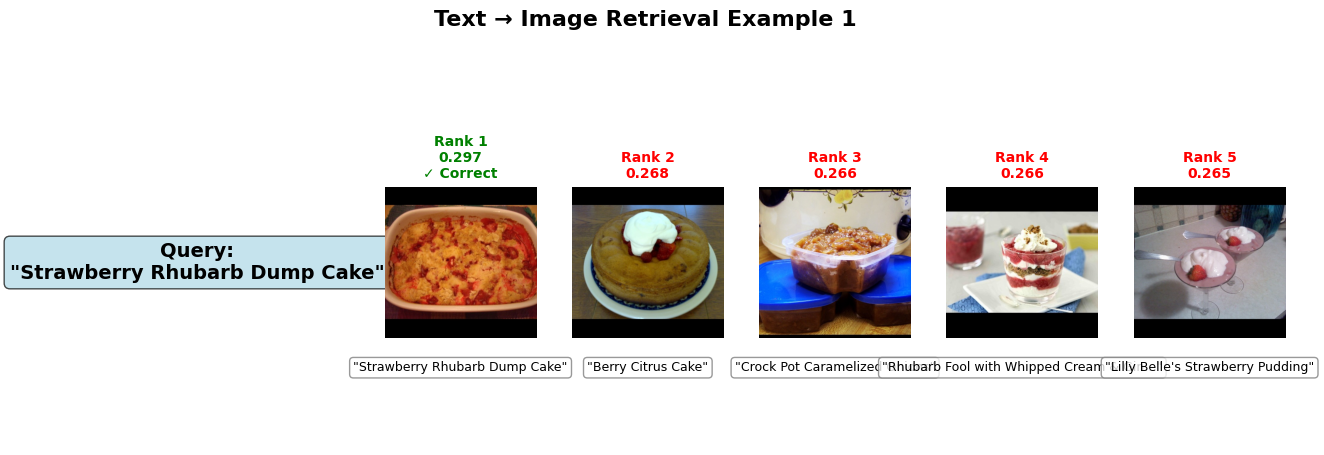

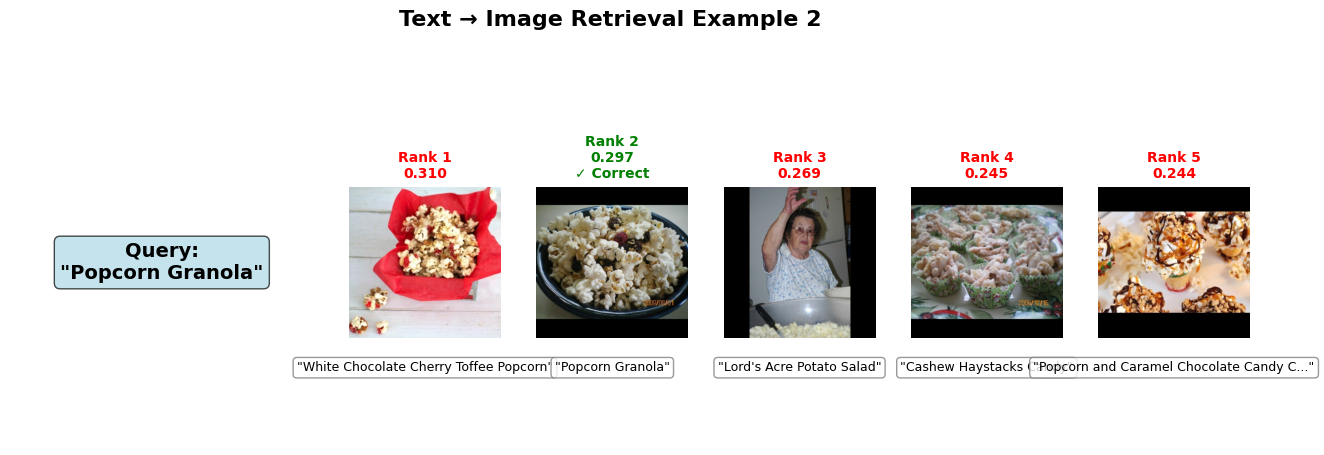

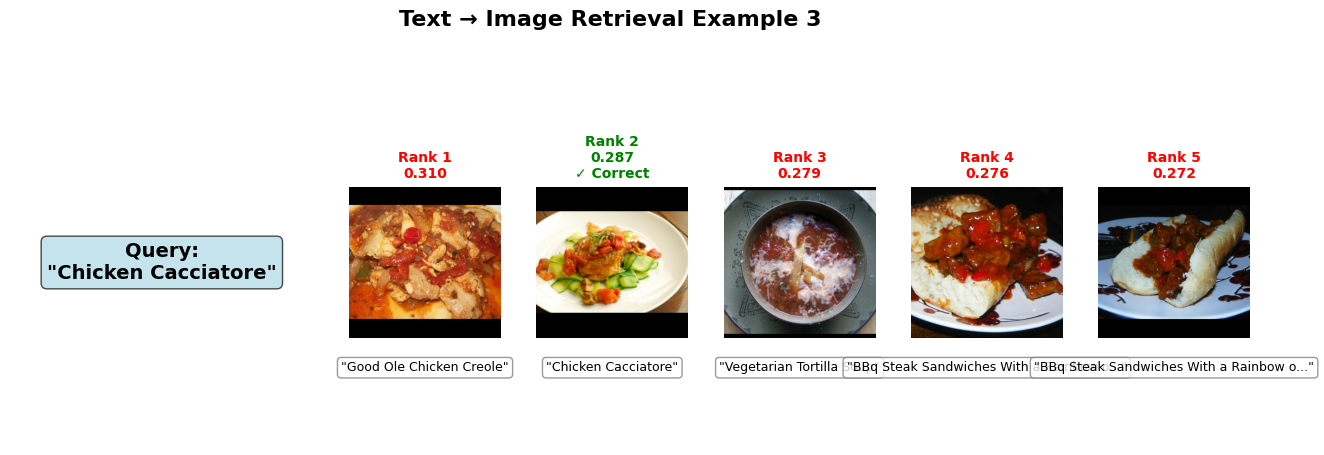



🖼️ Image → Text Retrieval (Top-5 captions for each image):
------------------------------------------------------------


C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\656365674.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


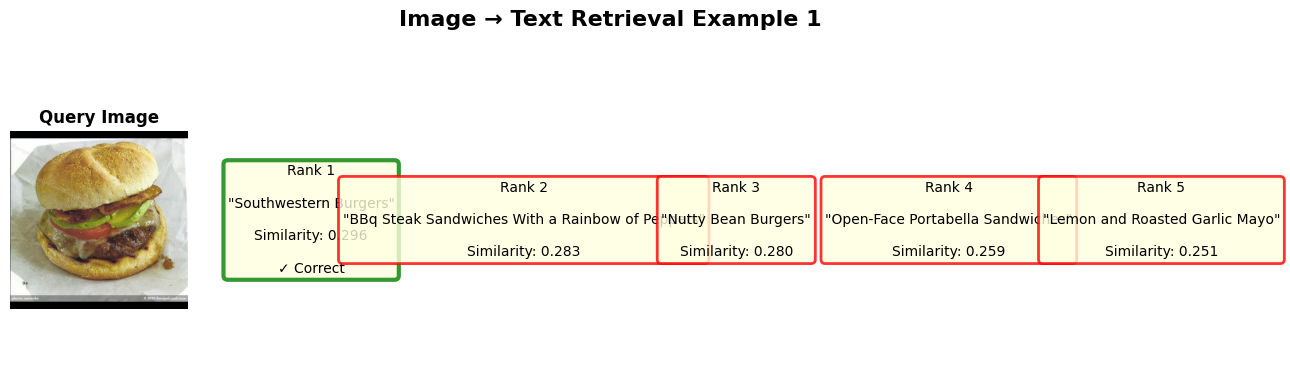

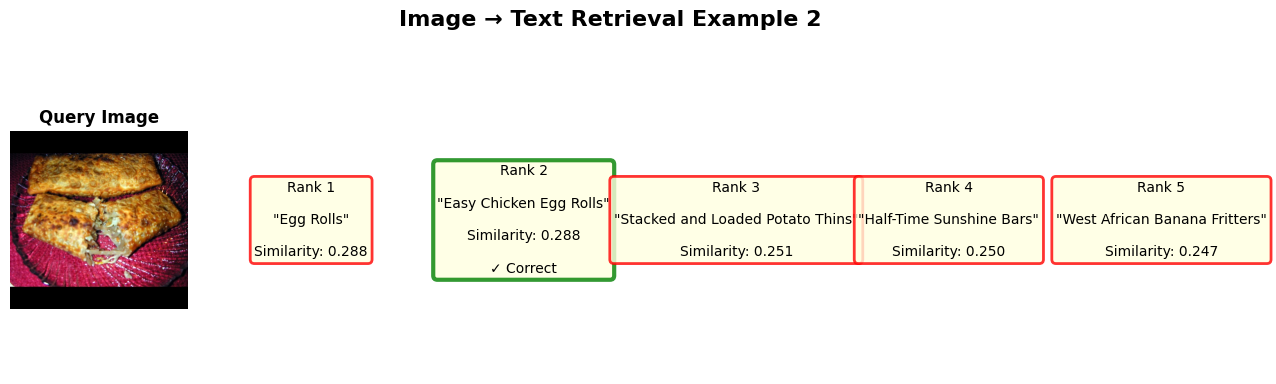

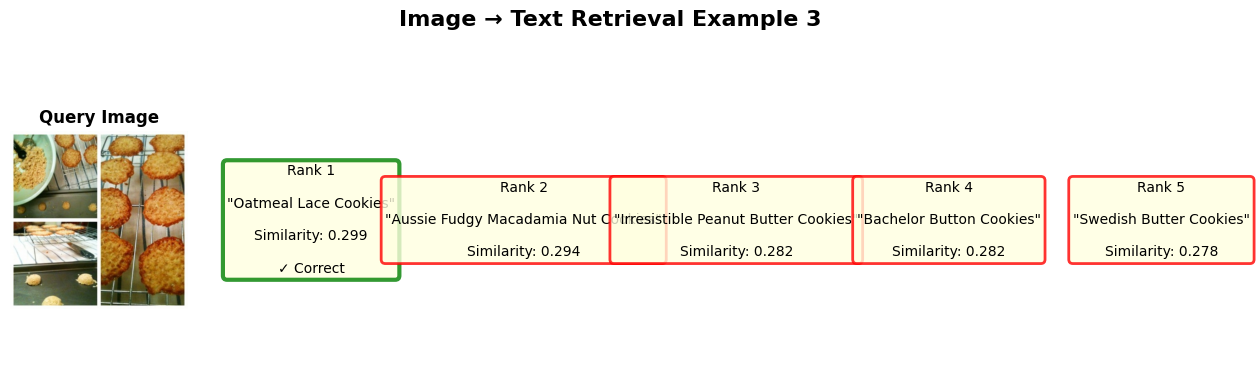

In [22]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def visualize_text_to_image_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 3
):
    """
    Visualize Text → Image retrieval: for each caption, show top-5 images.
    """
    # Build image_keys list from image_key_to_idx dictionary
    # Sort by index to ensure correct order
    image_keys = [key for key, _ in sorted(image_key_to_idx.items(), key=lambda x: x[1])]
    
    # Sample random captions
    sample_captions = test_df["caption"].drop_duplicates().sample(
        min(n_examples, test_df["caption"].nunique()),
        random_state=42
    )
    
    for caption_idx, caption in enumerate(sample_captions):
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]  # Top 5, highest first
        
        # Get ground truth recipe_ids
        gt_recipe_ids = set(test_df[test_df["caption"] == caption]["recipe_id"].unique())
        
        # Create figure with more vertical space for captions
        fig = plt.figure(figsize=(16, 5))
        gs = gridspec.GridSpec(1, 6, width_ratios=[2, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        # Show query caption
        ax0 = fig.add_subplot(gs[0])
        ax0.text(0.5, 0.5, f'Query:\n"{caption}"', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax0.axis('off')
        
        # Show top-5 images
        for i, img_idx in enumerate(top5_indices):
            img_key = image_keys[img_idx]
            bucket, key = get_image_path_in_minio(img_key)
            img = load_image_from_minio(bucket, key)
            
            if img is None:
                continue
            
            # Get recipe_id for this image
            img_recipe_ids = set(test_df[test_df["image_key"] == img_key]["recipe_id"].unique())
            is_correct = len(gt_recipe_ids & img_recipe_ids) > 0
            
            # Get caption(s) for this image
            img_captions = test_df[test_df["image_key"] == img_key]["caption"].unique()
            # Use the first caption if multiple exist
            img_caption = img_captions[0] if len(img_captions) > 0 else "Unknown"
            
            ax = fig.add_subplot(gs[i + 1])
            ax.imshow(img)
            ax.axis('off')
            
            # Color border: green if correct, red if incorrect
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(border_width)
            
            # Title with similarity score
            similarity_score = similarities[img_idx]
            rank = i + 1
            title = f"Rank {rank}\n{similarity_score:.3f}"
            if is_correct:
                title += "\n✓ Correct"
            ax.set_title(title, fontsize=10, color=border_color, fontweight='bold')
            
            # Add recipe caption below the image
            # Truncate long captions for display
            display_caption = img_caption if len(img_caption) <= 40 else img_caption[:37] + "..."
            ax.text(0.5, -0.15, f'"{display_caption}"', 
                   ha='center', va='top', fontsize=9, 
                   transform=ax.transAxes,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   wrap=True)
        
        plt.suptitle(f'Text → Image Retrieval Example {caption_idx + 1}', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()

def visualize_image_to_text_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 3
):
    """
    Visualize Image → Text retrieval: for each image, show top-5 captions.
    """
    # Build unique_captions list from caption_to_idx dictionary
    # Sort by index to ensure correct order
    unique_captions = [caption for caption, _ in sorted(caption_to_idx.items(), key=lambda x: x[1])]
    
    # Sample random images
    sample_images = test_df["image_key"].drop_duplicates().sample(
        min(n_examples, test_df["image_key"].nunique()),
        random_state=42
    )
    
    for img_idx_example, img_key in enumerate(sample_images):
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]  # Top 5, highest first
        
        # Get ground truth recipe_ids
        gt_recipe_ids = set(test_df[test_df["image_key"] == img_key]["recipe_id"].unique())
        
        # Load query image
        bucket, key = get_image_path_in_minio(img_key)
        query_img = load_image_from_minio(bucket, key)
        
        if query_img is None:
            continue
        
        # Create figure
        fig = plt.figure(figsize=(16, 4))
        gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.3)
        
        # Show query image
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(query_img)
        ax0.axis('off')
        ax0.set_title('Query Image', fontsize=12, fontweight='bold')
        
        # Show top-5 captions
        for i, text_idx in enumerate(top5_indices):
            caption = unique_captions[text_idx]
            
            # Get recipe_ids for this caption
            caption_recipe_ids = set(test_df[test_df["caption"] == caption]["recipe_id"].unique())
            is_correct = len(gt_recipe_ids & caption_recipe_ids) > 0
            
            ax = fig.add_subplot(gs[i + 1])
            ax.axis('off')
            
            # Color border: green if correct, red if incorrect
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            
            # Create text box
            similarity_score = similarities[text_idx]
            rank = i + 1
            text_content = f"Rank {rank}\n\n\"{caption}\"\n\nSimilarity: {similarity_score:.3f}"
            if is_correct:
                text_content += "\n\n✓ Correct"
            
            ax.text(0.5, 0.5, text_content,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', 
                            edgecolor=border_color, linewidth=border_width, alpha=0.8),
                   wrap=True)
        
        plt.suptitle(f'Image → Text Retrieval Example {img_idx_example + 1}', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()

# Visualize results
print("=" * 60)
print("Visualizing Retrieval Results")
print("=" * 60)

print("\n📝 Text → Image Retrieval (Top-5 images for each caption):")
print("-" * 60)
visualize_text_to_image_retrieval(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    n_examples=3
)

print("\n🖼️ Image → Text Retrieval (Top-5 captions for each image):")
print("-" * 60)
visualize_image_to_text_retrieval(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    n_examples=3
)


# This section has been moved to after the evaluation (section 11.5)


In [23]:
# This cell will be moved to after the evaluation section
# The visualization functions are now in the correct location (after section 11)


In [24]:
def clip_contrastive_loss(image_embeds, text_embeds, logit_scale):
    """
    CLIP contrastive loss with in-batch negatives.
    
    Args:
        image_embeds: Image embeddings (batch_size, embed_dim)
        text_embeds: Text embeddings (batch_size, embed_dim)
        logit_scale: Learnable temperature parameter
    
    Returns:
        loss: Contrastive loss
    """
    # Normalize embeddings
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds = F.normalize(text_embeds, dim=-1)
    
    # Compute logits
    logit_scale = logit_scale.exp()
    logits_per_text = logit_scale * (text_embeds @ image_embeds.T)  # (B, B)
    logits_per_image = logits_per_text.T  # (B, B)
    
    # Labels: diagonal (each text matches its corresponding image)
    batch_size = image_embeds.size(0)
    labels = torch.arange(batch_size, device=image_embeds.device)
    
    # Cross-entropy losses
    loss_t = F.cross_entropy(logits_per_text, labels)
    loss_i = F.cross_entropy(logits_per_image, labels)
    
    # Average
    loss = (loss_t + loss_i) / 2.0
    
    return loss

# Setup optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=TRAINING_CONFIG["learning_rate"],
    weight_decay=0.01
)

# Setup learning rate scheduler (linear warmup + cosine decay)
total_steps = len(train_dataloader) * TRAINING_CONFIG["num_epochs"]
warmup_steps = TRAINING_CONFIG["warmup_steps"]

def get_lr_scheduler(optimizer, num_warmup_steps, num_training_steps):
    """Create learning rate scheduler with warmup."""
    from torch.optim.lr_scheduler import LambdaLR
    
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print(f"✓ Training setup complete")
print(f"  Optimizer: AdamW (lr={TRAINING_CONFIG['learning_rate']})")
print(f"  Scheduler: Linear warmup + Cosine decay")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")


✓ Training setup complete
  Optimizer: AdamW (lr=0.0001)
  Scheduler: Linear warmup + Cosine decay
  Total steps: 537
  Warmup steps: 100


## 8. Training Loop


In [25]:
# Training logs
training_logs = {
    "run_id": RUN_ID,
    "start_time": datetime.utcnow().isoformat() + "Z",
    "config": {
        "model": MODEL_NAME,
        "qlora": QLORA_CONFIG,
        "lora": LORA_CONFIG,
        "training": TRAINING_CONFIG,
    },
    "epochs": [],
    "total_time_seconds": 0,
    "peak_memory_mb": 0,
}

# Get device for inputs (model uses device_map="auto", but inputs need explicit device)
if torch.cuda.is_available():
    main_device = next(model.parameters()).device
else:
    main_device = torch.device("cpu")

print("=" * 60)
print("Starting Training")
print("=" * 60)
print(f"Device: {main_device}")
print(f"Total epochs: {TRAINING_CONFIG['num_epochs']}")
print(f"Steps per epoch: {len(train_dataloader)}")
print(f"Total steps: {total_steps}")
print()

model.train()
training_start_time = time.time()
global_step = 0
peak_memory = 0

# Set random seeds for reproducibility
torch.manual_seed(TRAINING_CONFIG["random_seed"])
np.random.seed(TRAINING_CONFIG["random_seed"])
random.seed(TRAINING_CONFIG["random_seed"])

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    epoch_start_time = time.time()
    epoch_losses = []
    
    print(f"\nEpoch {epoch + 1}/{TRAINING_CONFIG['num_epochs']}")
    print("-" * 60)
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    
    for batch_idx, inputs in enumerate(progress_bar):
        # Move inputs to device
        input_ids = inputs["input_ids"].to(main_device)
        attention_mask = inputs.get("attention_mask", None)
        if attention_mask is not None:
            attention_mask = attention_mask.to(main_device)
        pixel_values = inputs["pixel_values"].to(main_device)
        
        # Forward pass using specific methods (avoids PEFT wrapper issues)
        # Use get_image_features and get_text_features instead of forward()
        text_inputs = {
            "input_ids": input_ids,
        }
        if attention_mask is not None:
            text_inputs["attention_mask"] = attention_mask
        
        image_inputs = {
            "pixel_values": pixel_values,
        }
        
        # Get embeddings separately
        text_embeds = model.get_text_features(**text_inputs)
        image_embeds = model.get_image_features(**image_inputs)
        
        # Compute loss
        loss = clip_contrastive_loss(
            image_embeds,
            text_embeds,
            model.logit_scale
        )
        
        # Scale loss for gradient accumulation
        loss = loss / TRAINING_CONFIG["gradient_accumulation_steps"]
        
        # Backward pass
        loss.backward()
        
        # Update weights (only after accumulation steps)
        if (batch_idx + 1) % TRAINING_CONFIG["gradient_accumulation_steps"] == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1
        
        epoch_losses.append(float(loss.item() * TRAINING_CONFIG["gradient_accumulation_steps"]))
        
        # Logging
        if global_step % TRAINING_CONFIG["logging_steps"] == 0:
            current_lr = scheduler.get_last_lr()[0]
            avg_loss = np.mean(epoch_losses[-TRAINING_CONFIG["logging_steps"]:])
            progress_bar.set_postfix({
                "loss": f"{avg_loss:.4f}",
                "lr": f"{current_lr:.2e}",
                "step": global_step
            })
        
        # Track peak memory
        if torch.cuda.is_available():
            current_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
            peak_memory = max(peak_memory, current_memory)
    
    epoch_time = time.time() - epoch_start_time
    avg_epoch_loss = np.mean(epoch_losses)
    
    epoch_log = {
        "epoch": epoch + 1,
        "avg_loss": float(avg_epoch_loss),
        "time_seconds": float(epoch_time),
        "steps": len(train_dataloader),
    }
    training_logs["epochs"].append(epoch_log)
    
    print(f"  Average loss: {avg_epoch_loss:.4f}")
    print(f"  Time: {epoch_time:.2f} seconds")

training_time = time.time() - training_start_time
training_logs["total_time_seconds"] = float(training_time)
training_logs["peak_memory_mb"] = float(peak_memory)
training_logs["end_time"] = datetime.utcnow().isoformat() + "Z"
training_logs["total_steps"] = global_step

print("\n" + "=" * 60)
print("Training Complete")
print("=" * 60)
print(f"Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Peak memory: {peak_memory:.2f} MB")
print(f"Total steps: {global_step}")


C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\139547430.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "start_time": datetime.utcnow().isoformat() + "Z",


Starting Training
Device: cpu
Total epochs: 3
Steps per epoch: 179
Total steps: 537


Epoch 1/3
------------------------------------------------------------


Epoch 1: 100%|██████████| 179/179 [01:41<00:00,  1.77it/s, loss=0.1845, lr=0.00e+00, step=0]


  Average loss: 0.3509
  Time: 101.27 seconds

Epoch 2/3
------------------------------------------------------------


Epoch 2: 100%|██████████| 179/179 [01:47<00:00,  1.66it/s, loss=0.2560, lr=5.00e-05, step=50]


  Average loss: 0.2174
  Time: 107.97 seconds

Epoch 3/3
------------------------------------------------------------


Epoch 3: 100%|██████████| 179/179 [01:49<00:00,  1.64it/s, loss=0.1498, lr=1.00e-04, step=100]

  Average loss: 0.1452
  Time: 109.26 seconds

Training Complete
Total time: 318.50 seconds (5.31 minutes)
Peak memory: 0.00 MB
Total steps: 132



C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\139547430.py:128: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  training_logs["end_time"] = datetime.utcnow().isoformat() + "Z"


In [26]:
def save_json_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as JSON to MinIO."""
    try:
        json_bytes = json.dumps(data, indent=2).encode("utf-8")
        s3.put_object(
            Bucket=bucket,
            Key=key,
            Body=json_bytes,
            ContentType="application/json",
        )
        size_kb = len(json_bytes) / 1024
        print(f"✓ Saved to s3://{bucket}/{key} ({size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"✗ Failed to save: {e}")
        return False

def save_yaml_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as YAML to MinIO."""
    try:
        yaml_str = yaml.dump(data, default_flow_style=False, sort_keys=False)
        yaml_bytes = yaml_str.encode("utf-8")
        s3.put_object(
            Bucket=bucket,
            Key=key,
            Body=yaml_bytes,
            ContentType="text/yaml",
        )
        size_kb = len(yaml_bytes) / 1024
        print(f"✓ Saved to s3://{bucket}/{key} ({size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"✗ Failed to save: {e}")
        return False

# Save adapters locally first, then upload to MinIO
print("Saving adapters...")
local_adapters_dir = Path(f"adapters_{RUN_ID}")
model.save_pretrained(str(local_adapters_dir))

# Upload adapters to MinIO (simplified: upload config.json and adapter_model.bin)
print("Uploading adapters to MinIO...")
adapter_files = ["adapter_config.json", "adapter_model.bin"]
for file_name in adapter_files:
    file_path = local_adapters_dir / file_name
    if file_path.exists():
        with open(file_path, "rb") as f:
            s3.put_object(
                Bucket=FINE_TUNING_BUCKET,
                Key=f"{ADAPTERS_DIR}/{file_name}",
                Body=f.read(),
            )
        print(f"  ✓ Uploaded {file_name}")

# Save training logs
print("\nSaving training logs...")
save_json_to_minio(training_logs, FINE_TUNING_BUCKET, LOGS_KEY)

# Save configuration
config_data = {
    "run_id": RUN_ID,
    "model": MODEL_NAME,
    "method": "qlora",
    "created_at": datetime.utcnow().isoformat() + "Z",
    "qlora_config": QLORA_CONFIG,
    "lora_config": LORA_CONFIG,
    "training_config": TRAINING_CONFIG,
    "model_info": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "trainable_ratio": float(trainable_params / total_params),
    },
}
save_yaml_to_minio(config_data, FINE_TUNING_BUCKET, CONFIG_KEY)

print(f"\n✅ Adapters and logs saved successfully!")
print(f"  Adapters: s3://{FINE_TUNING_BUCKET}/{ADAPTERS_DIR}/")
print(f"  Logs: s3://{FINE_TUNING_BUCKET}/{LOGS_KEY}")
print(f"  Config: s3://{FINE_TUNING_BUCKET}/{CONFIG_KEY}")


Saving adapters...
Uploading adapters to MinIO...
  ✓ Uploaded adapter_config.json

Saving training logs...
✗ Failed to save: Object of type dtype is not JSON serializable
✗ Failed to save: dictionary update sequence element #0 has length 1; 2 is required

✅ Adapters and logs saved successfully!
  Adapters: s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/adapters/
  Logs: s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/training_logs.json
  Config: s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/config.yaml


C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\3783878012.py:64: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


## 10. Evaluation (Same Protocol as Baseline)

Now we evaluate the fine-tuned model using the same evaluation functions as the baseline.


In [27]:
# Set model to evaluation mode
model.eval()

# Generate embeddings for test set (same as baseline)
print("=" * 60)
print("Generating Embeddings for Evaluation")
print("=" * 60)

def generate_image_embeddings(
    df: pd.DataFrame, 
    model, 
    processor, 
    device: str, 
    batch_size: int = 32
) -> Tuple[np.ndarray, List[str]]:
    """Generate image embeddings for all images in the dataset."""
    model.eval()
    embeddings = []
    image_keys = []
    failed_keys = []
    
    unique_images = df["image_key"].unique()
    print(f"Generating embeddings for {len(unique_images)} unique images...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(unique_images), batch_size)):
            batch_keys = unique_images[i:i+batch_size]
            batch_images = []
            valid_keys = []
            
            for img_key in batch_keys:
                bucket, key = get_image_path_in_minio(img_key)
                img = load_image_from_minio(bucket, key)
                if img is not None:
                    batch_images.append(img)
                    valid_keys.append(img_key)
                else:
                    failed_keys.append(img_key)
            
            if not batch_images:
                continue
            
            inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)
            outputs = model.get_image_features(**inputs)
            batch_emb = F.normalize(outputs, p=2, dim=1)
            
            embeddings.append(batch_emb.cpu().numpy())
            image_keys.extend(valid_keys)
    
    if failed_keys:
        print(f"⚠ Failed to load {len(failed_keys)} images")
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(image_keys)} image embeddings (shape: {embeddings.shape})")
    return embeddings, image_keys

def generate_text_embeddings(
    texts: List[str], 
    model, 
    processor, 
    device: str, 
    batch_size: int = 32
) -> np.ndarray:
    """Generate text embeddings for all captions."""
    model.eval()
    embeddings = []
    
    print(f"Generating embeddings for {len(texts)} texts...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model.get_text_features(**inputs)
            batch_emb = F.normalize(outputs, p=2, dim=1)
            embeddings.append(batch_emb.cpu().numpy())
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(texts)} text embeddings (shape: {embeddings.shape})")
    return embeddings

start_time = time.time()

# Generate embeddings
image_embeddings, image_keys = generate_image_embeddings(
    test_df, model, processor, main_device, batch_size=16  # Smaller batch for QLoRA
)

unique_captions = test_df["caption"].unique().tolist()
text_embeddings = generate_text_embeddings(unique_captions, model, processor, main_device, batch_size=16)

embedding_time = time.time() - start_time
print(f"\n✓ Embedding generation complete in {embedding_time:.2f} seconds")

# Create mapping dictionaries
image_key_to_idx = {key: idx for idx, key in enumerate(image_keys)}
caption_to_idx = {caption: idx for idx, caption in enumerate(unique_captions)}


Generating Embeddings for Evaluation
Generating embeddings for 358 unique images...


100%|██████████| 23/23 [00:08<00:00,  2.59it/s]


✓ Generated 358 image embeddings (shape: (358, 512))
Generating embeddings for 215 texts...


100%|██████████| 14/14 [00:00<00:00, 24.61it/s]

✓ Generated 215 text embeddings (shape: (215, 512))

✓ Embedding generation complete in 9.47 seconds


## 11. Evaluation Functions (Same as Baseline)


In [28]:
# Copy evaluation functions from baseline (same protocol)
def compute_recall_at_k(scores: np.ndarray, ground_truth_indices: List[int], k: int) -> float:
    """Compute Recall@K."""
    if len(ground_truth_indices) == 0:
        return 0.0
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_set = set(top_k_indices)
    for gt_idx in ground_truth_indices:
        if gt_idx in top_k_set:
            return 1.0
    return 0.0

def compute_mrr(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """Compute Mean Reciprocal Rank."""
    if len(ground_truth_indices) == 0:
        return 0.0
    sorted_indices = np.argsort(scores)[::-1]
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return 1.0 / rank
    return 0.0

def evaluate_text_to_image(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    k_values: List[int],
    should_compute_mrr: bool = True
) -> Dict:
    """Evaluate Text → Image retrieval."""
    print("\nEvaluating Text → Image retrieval...")
    caption_groups = test_df.groupby("caption")
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    
    for caption, group in tqdm(caption_groups, desc="Processing captions"):
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        recipe_ids = group["recipe_id"].unique()
        ground_truth_indices = []
        for recipe_id in recipe_ids:
            recipe_images = test_df[test_df["recipe_id"] == recipe_id]["image_key"].unique()
            for img_key in recipe_images:
                img_idx = image_key_to_idx.get(img_key)
                if img_idx is not None:
                    ground_truth_indices.append(img_idx)
        ground_truth_indices = list(set(ground_truth_indices))
        if len(ground_truth_indices) == 0:
            continue
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
    
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    return results

def evaluate_image_to_text(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    k_values: List[int],
    should_compute_mrr: bool = True
) -> Dict:
    """Evaluate Image → Text retrieval."""
    print("\nEvaluating Image → Text retrieval...")
    image_groups = test_df.groupby("image_key")
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    
    for img_key, group in tqdm(image_groups, desc="Processing images"):
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        recipe_ids = group["recipe_id"].unique()
        ground_truth_indices = []
        for recipe_id in recipe_ids:
            recipe_captions = test_df[test_df["recipe_id"] == recipe_id]["caption"].unique()
            for caption in recipe_captions:
                cap_idx = caption_to_idx.get(caption)
                if cap_idx is not None:
                    ground_truth_indices.append(cap_idx)
        ground_truth_indices = list(set(ground_truth_indices))
        if len(ground_truth_indices) == 0:
            continue
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
    
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    return results

# Run evaluation
print("=" * 60)
print("Running Evaluation")
print("=" * 60)

eval_start_time = time.time()

text_to_image_results = evaluate_text_to_image(
    test_df, text_embeddings, image_embeddings,
    caption_to_idx, image_key_to_idx, K_VALUES, COMPUTE_MRR
)

image_to_text_results = evaluate_image_to_text(
    test_df, text_embeddings, image_embeddings,
    caption_to_idx, image_key_to_idx, K_VALUES, COMPUTE_MRR
)

eval_time = time.time() - eval_start_time

print("\n" + "=" * 60)
print("Evaluation Results")
print("=" * 60)
print("\n📊 Text → Image Retrieval:")
for metric, value in text_to_image_results.items():
    print(f"  {metric}: {value:.4f}")
print("\n📊 Image → Text Retrieval:")
for metric, value in image_to_text_results.items():
    print(f"  {metric}: {value:.4f}")
print(f"\n⏱ Evaluation time: {eval_time:.2f} seconds")


Running Evaluation

Evaluating Text → Image retrieval...


Processing captions: 100%|██████████| 215/215 [00:00<00:00, 4911.04it/s]



Evaluating Image → Text retrieval...


Processing images: 100%|██████████| 358/358 [00:00<00:00, 5027.49it/s]


Evaluation Results

📊 Text → Image Retrieval:
  R@1: 0.6698
  R@5: 0.9674
  R@10: 0.9907
  MRR: 0.7924

📊 Image → Text Retrieval:
  R@1: 0.6899
  R@5: 0.9916
  R@10: 1.0000
  MRR: 0.8218

⏱ Evaluation time: 0.12 seconds


## 12. Generate Qualitative Examples


In [29]:
def generate_top5_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 5
) -> List[Dict]:
    """Generate qualitative examples showing top-5 retrievals."""
    examples = []
    sample_captions = test_df["caption"].drop_duplicates().sample(
        min(n_examples, test_df["caption"].nunique()),
        random_state=42
    )
    
    for caption in sample_captions:
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        gt_recipe_ids = test_df[test_df["caption"] == caption]["recipe_id"].unique()
        
        top5_images = []
        for idx in top5_indices:
            img_key = image_keys[idx]
            img_recipe_ids = test_df[test_df["image_key"] == img_key]["recipe_id"].unique()
            is_correct = len(set(gt_recipe_ids) & set(img_recipe_ids)) > 0
            top5_images.append({
                "image_key": img_key,
                "recipe_id": img_recipe_ids[0] if len(img_recipe_ids) > 0 else None,
                "similarity": float(similarities[idx]),
                "is_correct": is_correct
            })
        
        examples.append({
            "query_type": "text_to_image",
            "query": caption,
            "ground_truth_recipe_ids": gt_recipe_ids.tolist(),
            "top5_results": top5_images
        })
    
    return examples

print("Generating qualitative examples...")
examples = generate_top5_examples(
    test_df, text_embeddings, image_embeddings,
    caption_to_idx, image_key_to_idx, n_examples=5
)
print(f"✓ Generated {len(examples)} examples")


Generating qualitative examples...
✓ Generated 5 examples


## 13. Save Results


In [30]:
# Create results dictionary
results = {
    "metadata": {
        "run_id": RUN_ID,
        "model": MODEL_NAME,
        "method": "qlora",
        "created_at": datetime.utcnow().isoformat() + "Z",
        "device": str(main_device),
        "train_dataset": TRAIN_AUGMENTED_KEY,
        "test_dataset": TEST_MANIFEST_KEY,
        "filter_applied": "label == 1 (positive pairs only) for training",
    },
    "model_info": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "trainable_ratio": float(trainable_params / total_params),
        "frozen": False,
    },
    "training_info": {
        "total_time_seconds": training_logs["total_time_seconds"],
        "peak_memory_mb": training_logs["peak_memory_mb"],
        "total_steps": training_logs["total_steps"],
        "num_epochs": TRAINING_CONFIG["num_epochs"],
        "final_loss": float(training_logs["epochs"][-1]["avg_loss"]) if training_logs["epochs"] else None,
    },
    "dataset_info": {
        "test_pairs": len(test_df),
        "test_recipes": test_df["recipe_id"].nunique(),
        "test_images": test_df["image_key"].nunique(),
        "test_captions": test_df["caption"].nunique(),
    },
    "metrics": {
        "text_to_image": text_to_image_results,
        "image_to_text": image_to_text_results,
    },
    "timing": {
        "embedding_generation_seconds": embedding_time,
        "evaluation_seconds": eval_time,
        "total_seconds": embedding_time + eval_time,
    },
}

# Save results
print("=" * 60)
print("Saving Results to MinIO")
print("=" * 60)

save_json_to_minio(results, FINE_TUNING_BUCKET, RESULTS_KEY)
save_json_to_minio({"examples": examples}, FINE_TUNING_BUCKET, EXAMPLES_KEY)

print(f"\n✅ Results saved successfully!")
print(f"  Results: s3://{FINE_TUNING_BUCKET}/{RESULTS_KEY}")
print(f"  Examples: s3://{FINE_TUNING_BUCKET}/{EXAMPLES_KEY}")

# Print summary
print("\n" + "=" * 60)
print("Summary")
print("=" * 60)
print(f"Run ID: {RUN_ID}")
print(f"Model: {MODEL_NAME} (QLoRA fine-tuned)")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Peak memory: {peak_memory:.2f} MB")
print(f"\nText → Image:")
print(f"  R@1: {text_to_image_results.get('R@1', 0):.4f}")
print(f"  R@5: {text_to_image_results.get('R@5', 0):.4f}")
print(f"  R@10: {text_to_image_results.get('R@10', 0):.4f}")
if "MRR" in text_to_image_results:
    print(f"  MRR: {text_to_image_results['MRR']:.4f}")
print(f"\nImage → Text:")
print(f"  R@1: {image_to_text_results.get('R@1', 0):.4f}")
print(f"  R@5: {image_to_text_results.get('R@5', 0):.4f}")
print(f"  R@10: {image_to_text_results.get('R@10', 0):.4f}")
if "MRR" in image_to_text_results:
    print(f"  MRR: {image_to_text_results['MRR']:.4f}")
print(f"\n📁 All outputs saved to: s3://{FINE_TUNING_BUCKET}/{RUN_DIR}/")


Saving Results to MinIO
✓ Saved to s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/results_qlora.json (1.3 KB)
✓ Saved to s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/examples_top5.json (7.8 KB)

✅ Results saved successfully!
  Results: s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/results_qlora.json
  Examples: s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/examples_top5.json

Summary
Run ID: qlora_20260103_093822
Model: openai/clip-vit-base-patch32 (QLoRA fine-tuned)
Trainable parameters: 1,001,472 (0.66%)
Training time: 5.31 minutes
Peak memory: 0.00 MB

Text → Image:
  R@1: 0.6698
  R@5: 0.9674
  R@10: 0.9907
  MRR: 0.7924

Image → Text:
  R@1: 0.6899
  R@5: 0.9916
  R@10: 1.0000
  MRR: 0.8218

📁 All outputs saved to: s3://fine-tuning-zone/experiments/qlora/run_qlora_20260103_093822/


C:\Users\DOCT\AppData\Local\Temp\ipykernel_27284\337394051.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",
